# Brain Tumor MRI Classification – RNN

This notebook trains a **Recurrent Neural Network (RNN)** on the Brain Tumor MRI Dataset – Merged (4 classes).
- Shared preprocessing: grayscale, resize to 64×64, normalize
- Train/val split with stratification
- Metrics: Accuracy, F1-score, Confusion Matrix; plus learning curves

> Set `DATA_DIR` to your dataset root (with subfolders: `glioma/`, `meningioma/`, `pituitary/`, `no_tumor/`).

In [1]:
# Reproducibility
import os
import random
import numpy as np
import tensorflow as tf

SEED = 42

# Set Python random seed
random.seed(SEED)

# Set NumPy random seed
np.random.seed(SEED)

# Set TensorFlow random seed
tf.random.set_seed(SEED)

# Configure TensorFlow for deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Ensure reproducibility on GPU (if available)
os.environ['PYTHONHASHSEED'] = str(SEED)

print(f"✓ Reproducibility seeds set (SEED={SEED})")
print("  - Python random seed")
print("  - NumPy random seed")
print("  - TensorFlow random seed")
print("  - TensorFlow deterministic ops enabled")

✓ Reproducibility seeds set (SEED=42)
  - Python random seed
  - NumPy random seed
  - TensorFlow random seed
  - TensorFlow deterministic ops enabled


In [2]:
# --- Setup & Imports (TensorFlow/Keras) ---
import os, pathlib, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

print("TensorFlow:", tf.__version__)
DATA_DIR = "../data"  # <-- change if needed
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
SEED = 42

# --- Load image paths and labels from folder structure ---
data_root = pathlib.Path(DATA_DIR)
classes = ["glioma", "meningioma", "pituitary", "notumor"]
class_to_idx = {c:i for i,c in enumerate(classes)}

image_paths, labels = [], []
image_sizes = []  # Track original image sizes

for c in classes:
    class_dir = data_root / c
    if not class_dir.exists():
        raise FileNotFoundError(f"Missing folder: {class_dir}. Create subfolders for each class and add images.")
    for p in class_dir.glob("*"):
        if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp"}:
            image_paths.append(str(p))
            labels.append(class_to_idx[c])
            # Get original image size
            try:
                with Image.open(p) as img:
                    image_sizes.append(img.size)  # (width, height)
            except:
                image_sizes.append((0, 0))

print(f"Found {len(image_paths)} images across {len(classes)} classes.")

# Stratified split
X_train, X_val, y_train, y_val = train_test_split(
    image_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
)
print("Train:", len(X_train), " Val:", len(X_val))

TensorFlow: 2.16.1
Found 13351 images across 4 classes.
Train: 10680  Val: 2671


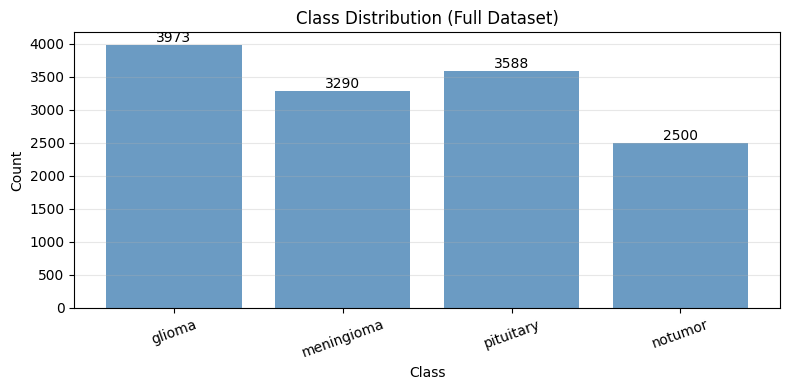

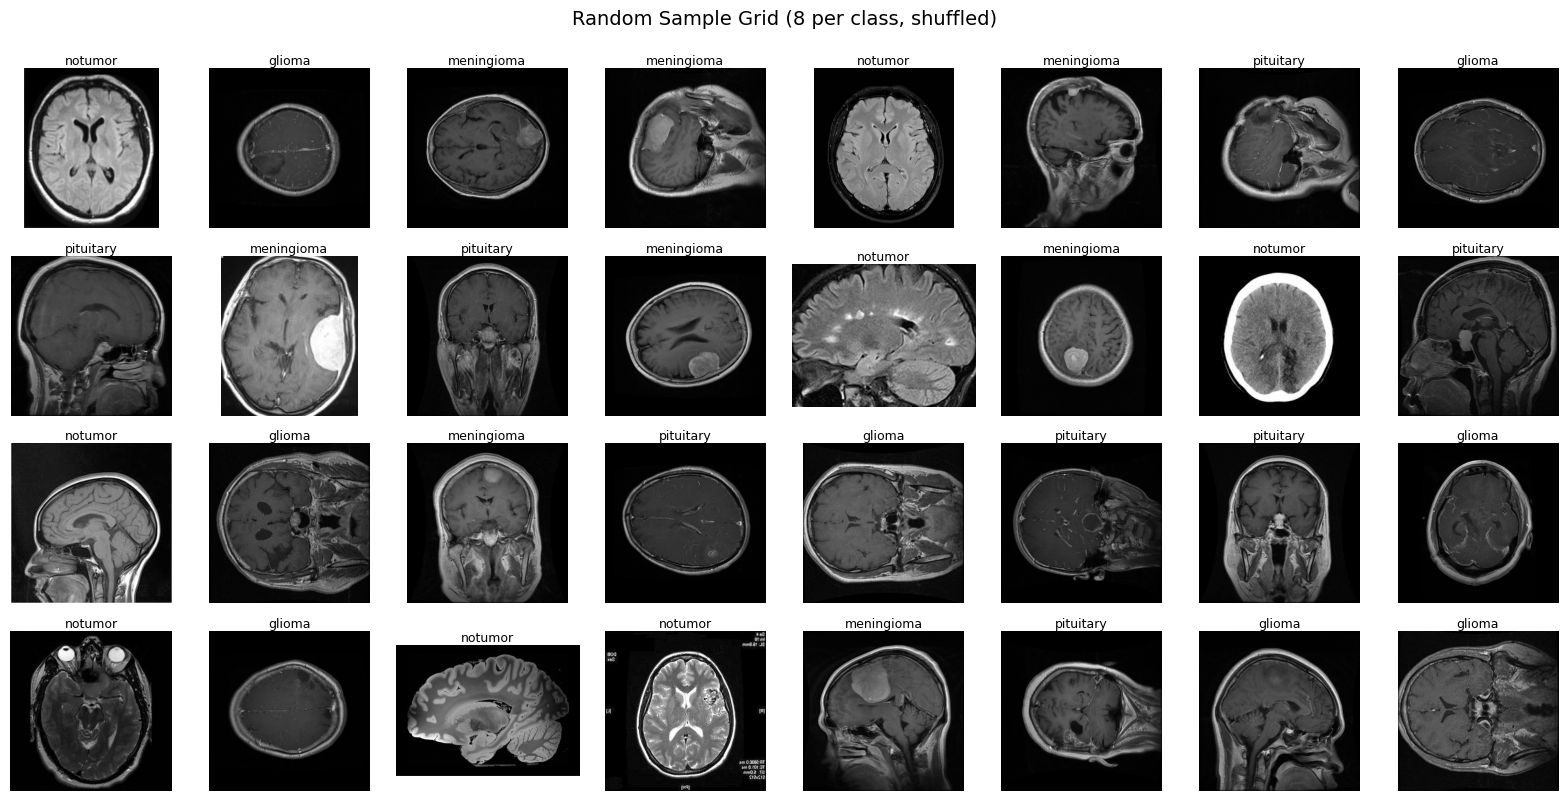

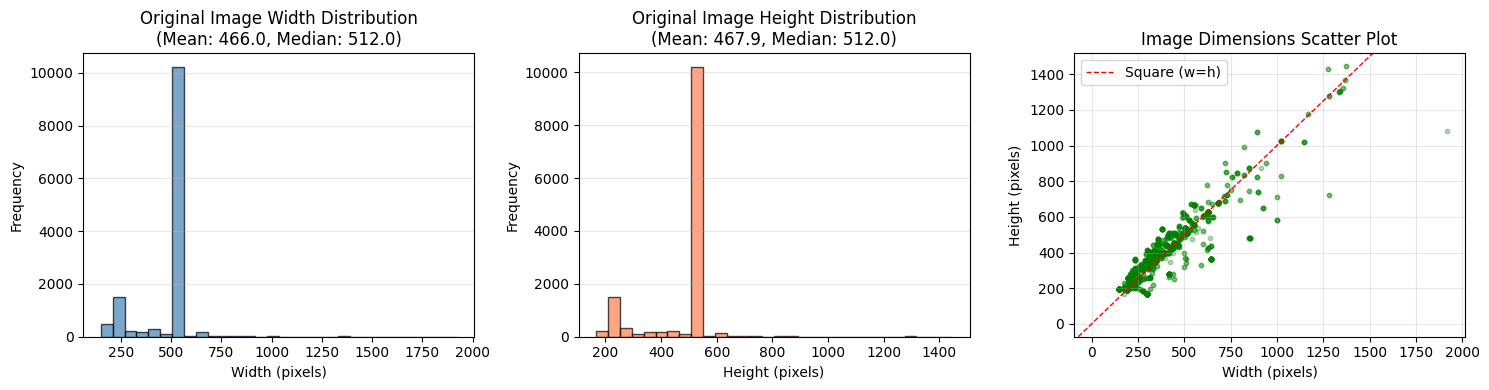


Original image size statistics:
  Width:  min=150, max=1920, mean=466.0
  Height: min=167, max=1446, mean=467.9
  Target resize: (64, 64)


In [3]:
# Dataset visuals
from collections import Counter

# 1. Bar chart of class counts
cnt = Counter(labels)
plt.figure(figsize=(8, 4))
bars = plt.bar(range(len(classes)), [cnt[i] for i in range(len(classes))], color='steelblue', alpha=0.8)
plt.xticks(range(len(classes)), classes, rotation=20)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution (Full Dataset)")
plt.grid(axis='y', alpha=0.3)
# Add count labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# 2. 4×8 grid of random images (2 per class, shuffled)
n_per_class = 8
samples_per_class = []

# Collect 8 random samples per class
for class_idx in range(len(classes)):
    class_indices = [i for i, lbl in enumerate(labels) if lbl == class_idx]
    random.seed(SEED)
    selected = random.sample(class_indices, min(n_per_class, len(class_indices)))
    samples_per_class.extend([(image_paths[i], labels[i]) for i in selected])

# Shuffle the collected samples
random.seed(SEED)
random.shuffle(samples_per_class)

# Display in 4×8 grid
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
axes = axes.flatten()

for idx, (img_path, lbl) in enumerate(samples_per_class[:32]):  # 4×8 = 32 images
    try:
        img = Image.open(img_path).convert('L')
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(classes[lbl], fontsize=9, pad=2)
        axes[idx].axis('off')
    except Exception as e:
        axes[idx].text(0.5, 0.5, 'Error', ha='center', va='center')
        axes[idx].axis('off')

# Hide any unused subplots
for idx in range(len(samples_per_class), 32):
    axes[idx].axis('off')

plt.suptitle("Random Sample Grid (8 per class, shuffled)", fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

# 3. Image size distribution (before resizing)
widths = [sz[0] for sz in image_sizes if sz[0] > 0]
heights = [sz[1] for sz in image_sizes if sz[1] > 0]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Width distribution
axes[0].hist(widths, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Original Image Width Distribution\n(Mean: {np.mean(widths):.1f}, Median: {np.median(widths):.1f})')
axes[0].grid(axis='y', alpha=0.3)

# Height distribution
axes[1].hist(heights, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Original Image Height Distribution\n(Mean: {np.mean(heights):.1f}, Median: {np.median(heights):.1f})')
axes[1].grid(axis='y', alpha=0.3)

# Scatter plot of width vs height
axes[2].scatter(widths, heights, alpha=0.3, s=10, c='green')
axes[2].set_xlabel('Width (pixels)')
axes[2].set_ylabel('Height (pixels)')
axes[2].set_title('Image Dimensions Scatter Plot')
axes[2].grid(True, alpha=0.3)
axes[2].axline((0, 0), slope=1, color='red', linestyle='--', linewidth=1, label='Square (w=h)')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"\nOriginal image size statistics:")
print(f"  Width:  min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.1f}")
print(f"  Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.1f}")
print(f"  Target resize: {IMG_SIZE}")

In [4]:
# --- TF data pipeline ---
AUTOTUNE = tf.data.AUTOTUNE

def load_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img.set_shape([None, None, 1])  # Set shape explicitly
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)/255.0
    return img, tf.cast(label, tf.int32)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train), seed=SEED)
train_ds = train_ds.map(load_img, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(load_img, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [5]:
# Data augmentation (applied during training only)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="augmentation")

In [6]:
# --- RNN model: 1D-Conv + BiLSTM ---
# Architecture: Reshape -> 1D Conv(64) -> BiLSTM(128) -> Dense(4)
# Treats image rows as sequences, extracts temporal patterns with Conv + BiLSTM

inputs = layers.Input(shape=(*IMG_SIZE, 1))
x = data_augmentation(inputs)

# Reshape: (64, 64, 1) -> (64, 64) - treat rows as time steps, columns as features
x = layers.Reshape((IMG_SIZE[0], IMG_SIZE[1]))(x)

# 1D Convolution: Extract local patterns along each row
x = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=2)(x)  # (32, 64)

# Bidirectional LSTM: Capture temporal dependencies in both directions
x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
x = layers.Dropout(0.5)(x)

# Classification head
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs, outputs, name='RNN_Conv1D_BiLSTM')
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "RNN_Conv1D_BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 64, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,140 (918.52 KB)

 Trainable params: 235,012 (918.02 KB)

 Non-trainable params: 128 (512.00 B)

In [7]:
# =============================
# Optional: CNN Feature Extractor + BiLSTM Variant
# =============================
# This variant uses a small CNN to extract spatial features first,
# then feeds them to BiLSTM for temporal modeling.
# Uncomment to use this instead of the 1D-Conv + BiLSTM model above.

"""
inputs_cnn = layers.Input(shape=(*IMG_SIZE, 1))
x = data_augmentation(inputs_cnn)

# Small CNN: Extract spatial features
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)  # (32, 32, 32)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)  # (16, 16, 64)

# Reshape for RNN: (batch, 16, 16*64=1024)
x = layers.Reshape((16, 16 * 64))(x)

# BiLSTM: Model temporal dependencies across spatial feature maps
x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
x = layers.Dropout(0.5)(x)

# Classification head
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs_cnn = layers.Dense(4, activation='softmax')(x)

model_cnn_rnn = models.Model(inputs_cnn, outputs_cnn, name='CNN_BiLSTM')
model_cnn_rnn.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_cnn_rnn.summary()

# To use this model, replace 'model' with 'model_cnn_rnn' in the training cell
"""

print("✓ CNN + BiLSTM variant available (commented out)")

✓ CNN + BiLSTM variant available (commented out)


In [8]:
# --- Save Model Diagram ---
from pathlib import Path

model_name = "rnn"
artifacts_dir = Path(f"../artifacts/{model_name}")
artifacts_dir.mkdir(parents=True, exist_ok=True)

# Generate model diagram using TensorFlow utilities
try:
    tf.keras.utils.plot_model(
        model, 
        to_file=str(artifacts_dir / 'model.png'), 
        show_shapes=True, 
        show_layer_names=True,
        rankdir='TB',  # Top to Bottom
        expand_nested=True,
        dpi=120
    )
    print(f"✓ Model diagram saved to {artifacts_dir / 'model.png'}")
except Exception as e:
    print(f"⚠ Could not generate model diagram image: {e}")
    print("  (This usually means graphviz is not installed)")
    
# Always save a text summary as backup (with UTF-8 encoding for Unicode characters)
with open(artifacts_dir / 'model.txt', 'w', encoding='utf-8') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print(f"✓ Model architecture summary saved to {artifacts_dir / 'model.txt'}")


You must install pydot (`pip install pydot`) for `plot_model` to work.
✓ Model diagram saved to ..\artifacts\rnn\model.png


✓ Model architecture summary saved to ..\artifacts\rnn\model.txt


Epoch 1/30
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4675 - loss: 1.1670
Epoch 1: val_accuracy improved from None to 0.59528, saving model to ..\artifacts\rnn\best_model.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.5258 - loss: 1.0711 - val_accuracy: 0.5953 - val_loss: 0.9707 - learning_rate: 0.0010
Epoch 2/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6082 - loss: 0.9243
Epoch 2: val_accuracy improved from 0.59528 to 0.67690, saving model to ..\artifacts\rnn\best_model.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.6227 - loss: 0.8999 - val_accuracy: 0.6769 - val_loss: 0.7658 - learning_rate: 0.0010
Epoch 3/30
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6518 - loss: 0.8373
Epoch 3: val_accuracy improved from 0.67690 to 0.72445, saving model to ..\artifacts\rnn\best_model.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.6591 - loss: 0.8257 - val_accuracy: 0.7244 - val_loss: 0.7212 - learning_rate: 0.0010
Epoch 4/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6831 - loss: 0.7819
Epoch 4: val_accuracy did not improve from 0.72445
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.6892 - loss: 0.7617 - val_accuracy: 0.6908 - val_loss: 0.7305 - learning_rate: 0.0010
Epoch 5/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7029 - loss: 0.7274
Epoch 5: val_accuracy did not improve from 0.72445
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7068 - loss: 0.7205 - val_accuracy: 0.6207 - val_loss: 0.8431 - learning_rate: 0.0010
Epoch 6/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7140 - loss: 0.7101
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_accuracy did not improve from 0.72445
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7218 - loss: 0.6900 - v

334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7534 - loss: 0.6216 - val_accuracy: 0.7518 - val_loss: 0.6162 - learning_rate: 5.0000e-04
Epoch 8/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7686 - loss: 0.5892
Epoch 8: val_accuracy improved from 0.75178 to 0.80082, saving model to ..\artifacts\rnn\best_model.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7649 - loss: 0.5895 - val_accuracy: 0.8008 - val_loss: 0.5101 - learning_rate: 5.0000e-04
Epoch 9/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7711 - loss: 0.5690
Epoch 9: val_accuracy did not improve from 0.80082
334/334 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7714 - loss: 0.5702 - val_accuracy: 0.7166 - val_loss: 0.6388 - learning_rate: 5.0000e-04
Epoch 10/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7835 - loss: 0.5448
Epoch 10: val_accuracy improved from 0.80082 to 0.80906, saving model to ..\artifacts\rnn\best_model.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.7860 - loss: 0.5474 - val_accuracy: 0.8091 - val_loss: 0.4915 - learning_rate: 5.0000e-04
Epoch 11/30
332/334 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7958 - loss: 0.5263
Epoch 11: val_accuracy did not improve from 0.80906
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.7928 - loss: 0.5260 - val_accuracy: 0.7960 - val_loss: 0.5067 - learning_rate: 5.0000e-04
Epoch 12/30
332/334 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7934 - loss: 0.5278
Epoch 12: val_accuracy improved from 0.80906 to 0.82815, saving model to ..\artifacts\rnn\best_model.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7993 - loss: 0.5157 - val_accuracy: 0.8282 - val_loss: 0.4449 - learning_rate: 5.0000e-04
Epoch 13/30
332/334 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7997 - loss: 0.5131
Epoch 13: val_accuracy did not improve from 0.82815
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8036 - loss: 0.5055 - val_accuracy: 0.8225 - val_loss: 0.4480 - learning_rate: 5.0000e-04
Epoch 14/30
332/334 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8025 - loss: 0.4988
Epoch 14: val_accuracy improved from 0.82815 to 0.83302, saving model to ..\artifacts\rnn\best_model.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8104 - loss: 0.4863 - val_accuracy: 0.8330 - val_loss: 0.4462 - learning_rate: 5.0000e-04
Epoch 15/30
332/334 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8153 - loss: 0.4770
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: val_accuracy did not improve from 0.83302
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.8171 - loss: 0.4746 - val_accuracy: 0.7967 - val_loss: 0.5102 - learning_rate: 5.0000e-04
Epoch 16/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8231 - loss: 0.4499
Epoch 16: val_accuracy improved from 0.83302 to 0.84912, saving model to ..\artifacts\rnn\best_model.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8309 - loss: 0.4392 - val_accuracy: 0.8491 - val_loss: 0.3813 - learning_rate: 2.5000e-04
Epoch 17/30
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8393 - loss: 0.4152
Epoch 17: val_accuracy improved from 0.84912 to 0.86410, saving model to ..\artifacts\rnn\best_model.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.8408 - loss: 0.4159 - val_accuracy: 0.8641 - val_loss: 0.3578 - learning_rate: 2.5000e-04
Epoch 18/30
332/334 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8435 - loss: 0.4103
Epoch 18: val_accuracy did not improve from 0.86410
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8425 - loss: 0.4111 - val_accuracy: 0.8622 - val_loss: 0.3571 - learning_rate: 2.5000e-04
Epoch 19/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8476 - loss: 0.3968
Epoch 19: val_accuracy did not improve from 0.86410
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.8436 - loss: 0.4011 - val_accuracy: 0.8207 - val_loss: 0.4473 - learning_rate: 2.5000e-04
Epoch 20/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8531 - loss: 0.3790
Epoch 20: val_accuracy improved from 0.86410 to 0.86634, saving model to ..\artifacts\rnn\best_model.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.8523 - loss: 0.3883 - val_accuracy: 0.8663 - val_loss: 0.3570 - learning_rate: 2.5000e-04
Epoch 21/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8546 - loss: 0.3735
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 21: val_accuracy did not improve from 0.86634
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.8501 - loss: 0.3875 - val_accuracy: 0.8289 - val_loss: 0.4186 - learning_rate: 2.5000e-04
Epoch 22/30
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8598 - loss: 0.3623
Epoch 22: val_accuracy did not improve from 0.86634
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8598 - loss: 0.3655 - val_accuracy: 0.8630 - val_loss: 0.3412 - learning_rate: 1.2500e-04
Epoch 23/30
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8670 - loss: 0.3635
Epoch 23: val_accuracy improved from 0.86634 to 0.86821, saving model to ..\artifacts\rnn\best_model.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.8649 - loss: 0.3657 - val_accuracy: 0.8682 - val_loss: 0.3432 - learning_rate: 1.2500e-04
Epoch 24/30
332/334 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8629 - loss: 0.3615
Epoch 24: val_accuracy improved from 0.86821 to 0.87420, saving model to ..\artifacts\rnn\best_model.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.8646 - loss: 0.3551 - val_accuracy: 0.8742 - val_loss: 0.3249 - learning_rate: 1.2500e-04
Epoch 25/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8625 - loss: 0.3655
Epoch 25: val_accuracy did not improve from 0.87420
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.8640 - loss: 0.3574 - val_accuracy: 0.8693 - val_loss: 0.3473 - learning_rate: 1.2500e-04
Epoch 26/30
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8779 - loss: 0.3391
Epoch 26: val_accuracy improved from 0.87420 to 0.88019, saving model to ..\artifacts\rnn\best_model.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.8720 - loss: 0.3445 - val_accuracy: 0.8802 - val_loss: 0.3191 - learning_rate: 1.2500e-04
Epoch 27/30
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8676 - loss: 0.3500
Epoch 27: val_accuracy improved from 0.88019 to 0.88057, saving model to ..\artifacts\rnn\best_model.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.8666 - loss: 0.3491 - val_accuracy: 0.8806 - val_loss: 0.3078 - learning_rate: 1.2500e-04
Epoch 28/30
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8700 - loss: 0.3340
Epoch 28: val_accuracy did not improve from 0.88057
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8696 - loss: 0.3432 - val_accuracy: 0.8723 - val_loss: 0.3366 - learning_rate: 1.2500e-04
Epoch 29/30
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8761 - loss: 0.3372
Epoch 29: val_accuracy improved from 0.88057 to 0.88469, saving model to ..\artifacts\rnn\best_model.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.8721 - loss: 0.3415 - val_accuracy: 0.8847 - val_loss: 0.3029 - learning_rate: 1.2500e-04
Epoch 30/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8698 - loss: 0.3409
Epoch 30: val_accuracy did not improve from 0.88469
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8736 - loss: 0.3354 - val_accuracy: 0.8791 - val_loss: 0.3046 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 29.


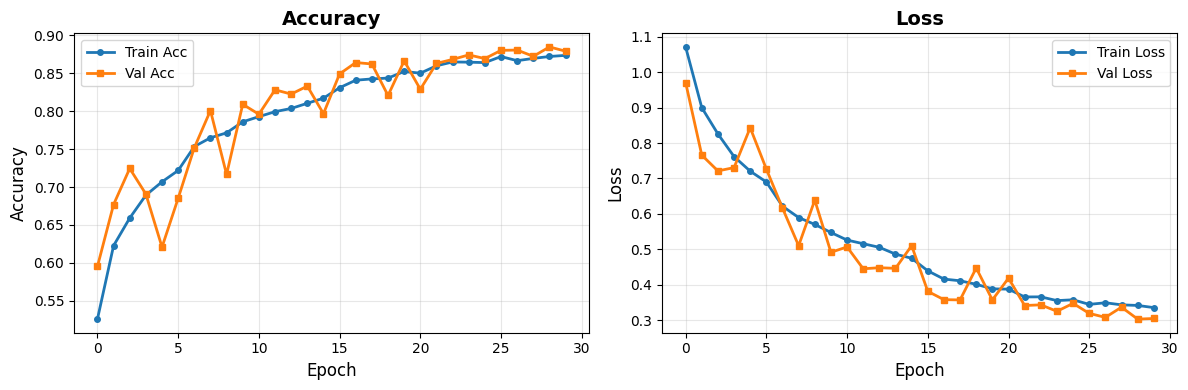

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


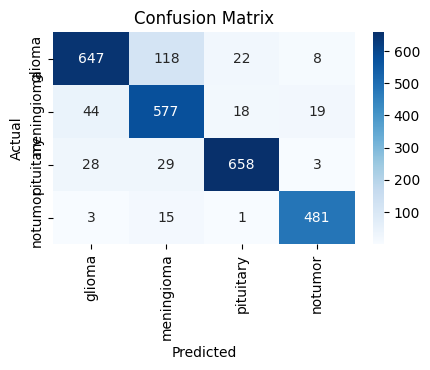

              precision    recall  f1-score   support

      glioma       0.90      0.81      0.85       795
  meningioma       0.78      0.88      0.83       658
   pituitary       0.94      0.92      0.93       718
     notumor       0.94      0.96      0.95       500

    accuracy                           0.88      2671
   macro avg       0.89      0.89      0.89      2671
weighted avg       0.89      0.88      0.89      2671

Weighted F1: 0.8851623540352226


In [9]:
# --- Train with callbacks ---
EPOCHS = 30

# Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(artifacts_dir / 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# --- Learning curves ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
axes[0].plot(history.history["accuracy"], label="Train Acc", linewidth=2, marker='o', markersize=4)
axes[0].plot(history.history["val_accuracy"], label="Val Acc", linewidth=2, marker='s', markersize=4)
axes[0].set_title("Accuracy", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Accuracy", fontsize=12)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history["loss"], label="Train Loss", linewidth=2, marker='o', markersize=4)
axes[1].plot(history.history["val_loss"], label="Val Loss", linewidth=2, marker='s', markersize=4)
axes[1].set_title("Loss", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Loss", fontsize=12)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Evaluation ---
y_true = np.array(y_val)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4.5,3.8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix"); plt.ylabel("Actual"); plt.xlabel("Predicted"); plt.tight_layout(); plt.show()

print(classification_report(y_true, y_pred, target_names=classes))
print("Weighted F1:", f1_score(y_true, y_pred, average="weighted"))


Total wrong predictions: 308 / 2671


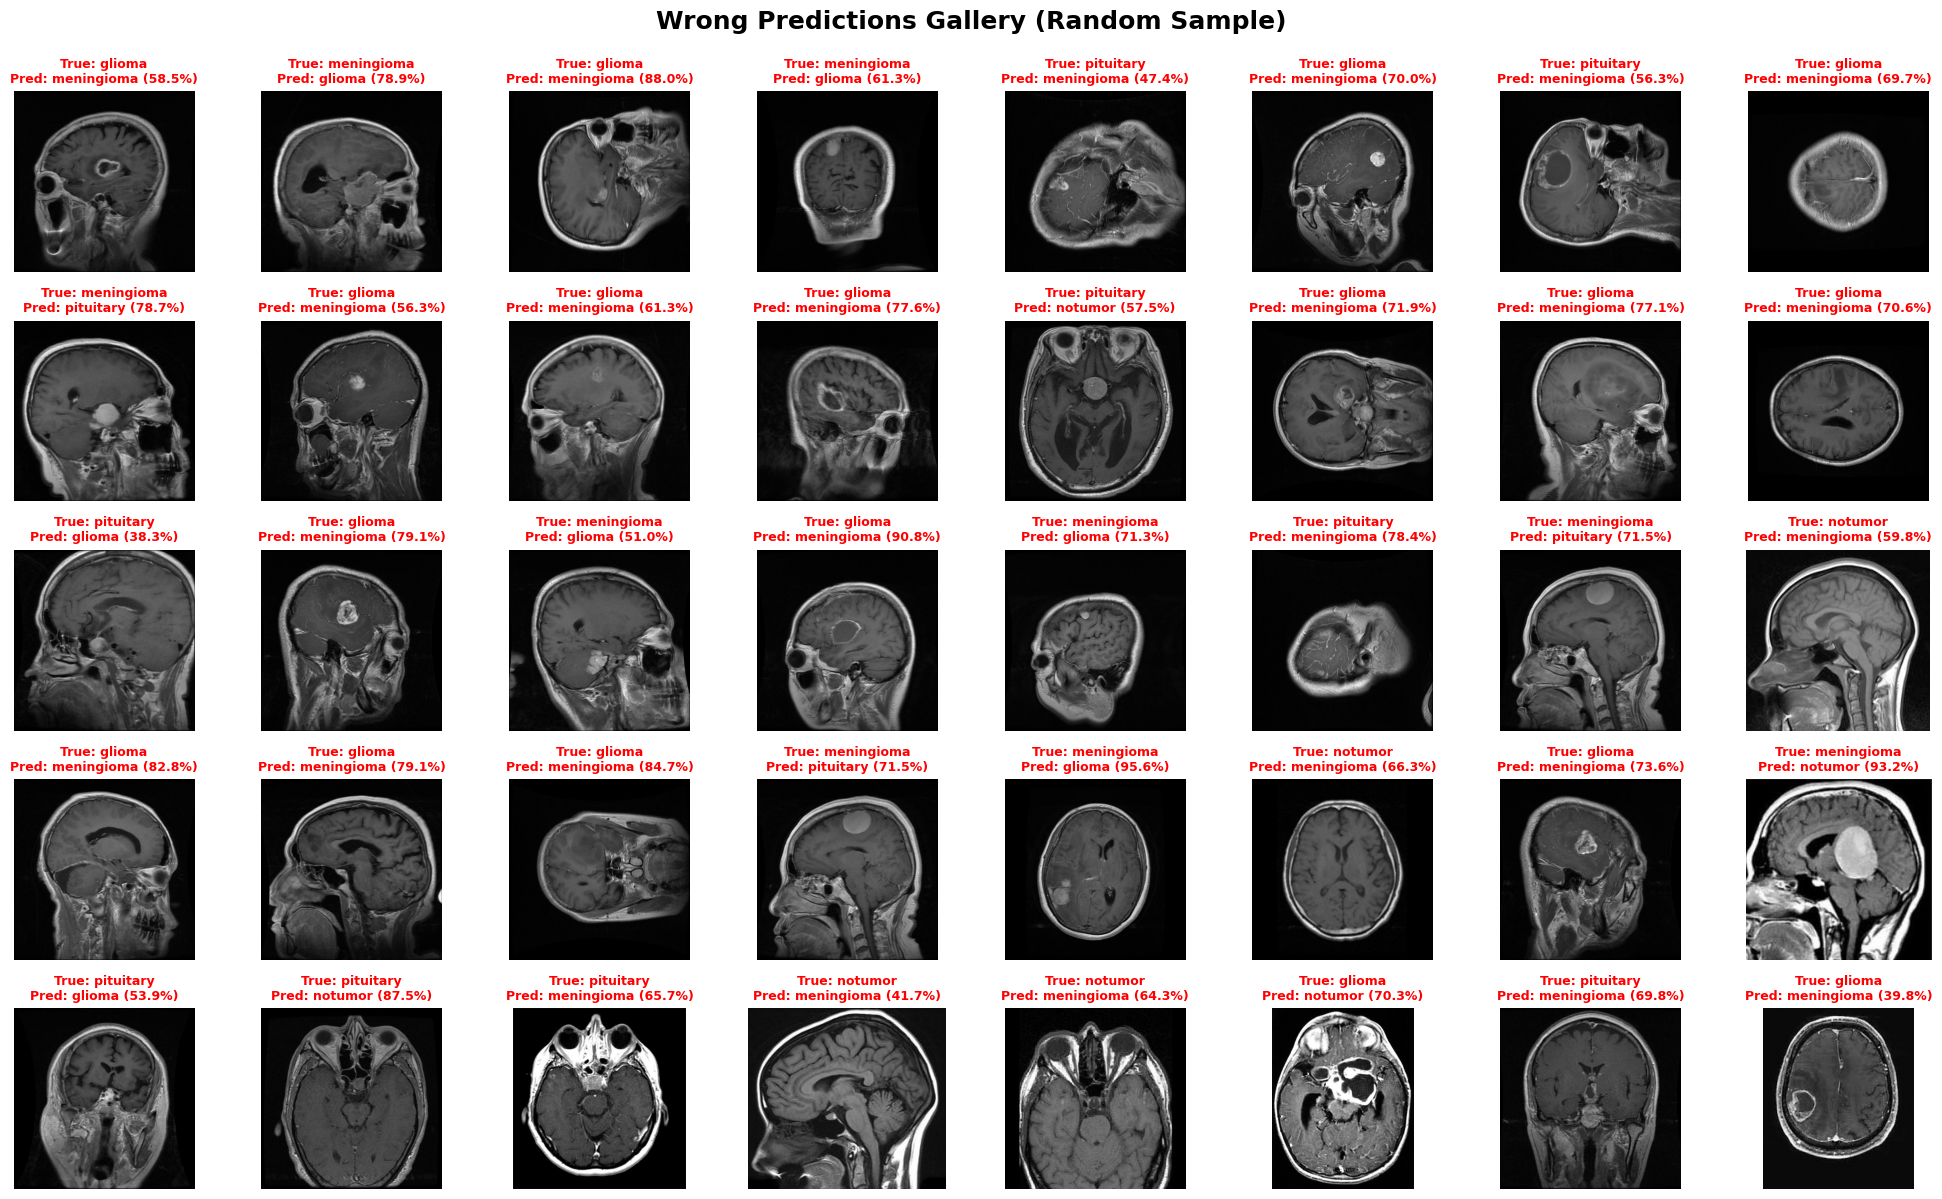

✓ Wrong predictions gallery saved to ..\artifacts\rnn\wrong_predictions.png


In [10]:
# =============================
# Wrong Predictions Gallery (5×8 grid = 40 images)
# =============================

# Identify all wrong predictions
wrong_indices = np.where(y_pred != y_true)[0]
print(f"\nTotal wrong predictions: {len(wrong_indices)} / {len(y_true)}")

# Sample up to 40 random wrong predictions
num_samples = min(40, len(wrong_indices))
sampled_wrong = np.random.choice(wrong_indices, size=num_samples, replace=False)

fig, axes = plt.subplots(5, 8, figsize=(20, 12))
fig.suptitle('Wrong Predictions Gallery (Random Sample)', fontsize=18, fontweight='bold', y=0.995)

for idx, ax in enumerate(axes.flat):
    if idx < len(sampled_wrong):
        i = sampled_wrong[idx]
        img_path = X_val[i]
        img = Image.open(img_path).convert('L')
        
        true_class = classes[y_true[i]]
        pred_class = classes[y_pred[i]]
        confidence = y_pred_probs[i, y_pred[i]] * 100
        
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(
            f'True: {true_class}\nPred: {pred_class} ({confidence:.1f}%)',
            fontsize=9,
            color='red',
            fontweight='bold'
        )
    else:
        ax.axis('off')

plt.tight_layout()
plt.savefig(artifacts_dir / 'wrong_predictions.png', dpi=120, bbox_inches='tight')
plt.show()

print(f"✓ Wrong predictions gallery saved to {artifacts_dir / 'wrong_predictions.png'}")

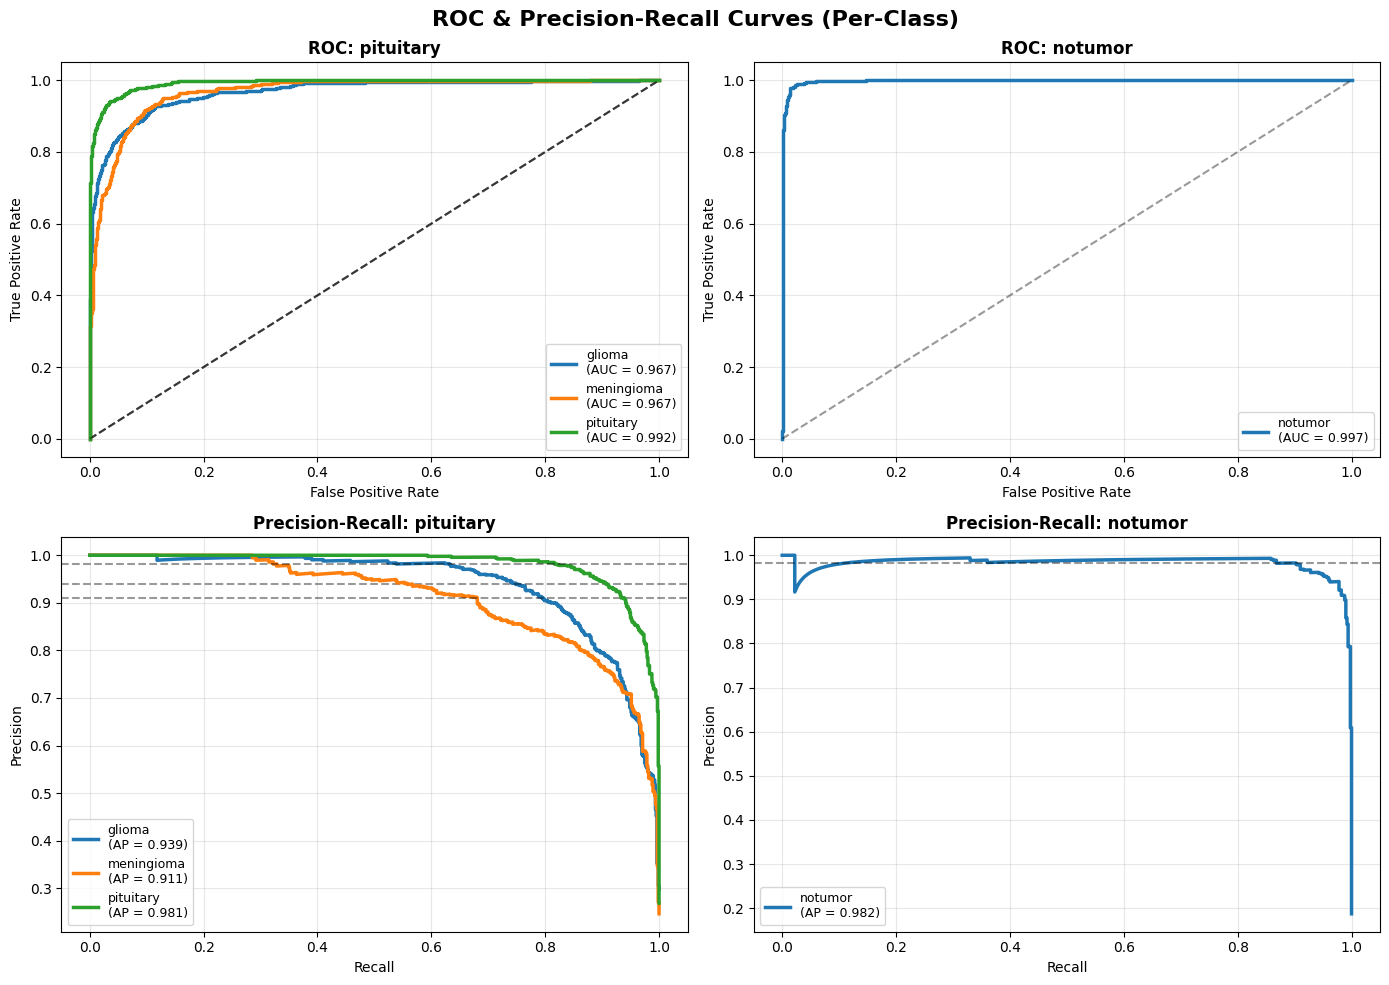

✓ ROC & PR curves saved to ..\artifacts\rnn\roc_pr_curves.png
✓ Curve data saved to ..\artifacts\rnn\roc_pr_curves.pkl


In [11]:
# =============================
# ROC & Precision-Recall Curves (Per-Class)
# =============================
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class ROC/PR
y_true_bin = label_binarize(y_true, classes=range(4))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('ROC & Precision-Recall Curves (Per-Class)', fontsize=16, fontweight='bold')

roc_data = {}
pr_data = {}

for i, cls in enumerate(classes):
    # ROC curve
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_data[cls] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])
    pr_data[cls] = {'precision': precision, 'recall': recall, 'avg_precision': avg_precision}
    
    # Plot ROC
    ax_roc = axes[0, i // 2] if i < 2 else axes[0, i % 2]
    ax_roc.plot(fpr, tpr, linewidth=2.5, label=f'{cls}\n(AUC = {roc_auc:.3f})')
    ax_roc.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.4)
    ax_roc.set_title(f'ROC: {cls}', fontsize=12, fontweight='bold')
    ax_roc.set_xlabel('False Positive Rate', fontsize=10)
    ax_roc.set_ylabel('True Positive Rate', fontsize=10)
    ax_roc.legend(loc='lower right', fontsize=9)
    ax_roc.grid(True, alpha=0.3)
    
    # Plot PR
    ax_pr = axes[1, i // 2] if i < 2 else axes[1, i % 2]
    ax_pr.plot(recall, precision, linewidth=2.5, label=f'{cls}\n(AP = {avg_precision:.3f})')
    ax_pr.axhline(y=avg_precision, color='k', linestyle='--', linewidth=1.5, alpha=0.4)
    ax_pr.set_title(f'Precision-Recall: {cls}', fontsize=12, fontweight='bold')
    ax_pr.set_xlabel('Recall', fontsize=10)
    ax_pr.set_ylabel('Precision', fontsize=10)
    ax_pr.legend(loc='best', fontsize=9)
    ax_pr.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(artifacts_dir / 'roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Save curve data
import pickle
with open(artifacts_dir / 'roc_pr_curves.pkl', 'wb') as f:
    pickle.dump({'roc': roc_data, 'pr': pr_data}, f)

print(f"✓ ROC & PR curves saved to {artifacts_dir / 'roc_pr_curves.png'}")
print(f"✓ Curve data saved to {artifacts_dir / 'roc_pr_curves.pkl'}")

In [12]:
# Save artifacts
import json
import pickle
import pandas as pd
from pathlib import Path
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

# 1. Ensure artifacts/<model_name>/ exists
model_name = "rnn"
artifacts_dir = Path(f"../artifacts/{model_name}")
artifacts_dir.mkdir(parents=True, exist_ok=True)
print(f"Artifacts directory: {artifacts_dir}")

# 2. Compute classification metrics
y_true = np.array(y_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get classification report as dict
report_dict = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")
weighted_f1 = f1_score(y_true, y_pred, average="weighted")

metrics = {
    "accuracy": float(acc),
    "macro_f1": float(macro_f1),
    "weighted_f1": float(weighted_f1),
    "classification_report": report_dict
}

# 3. Save metrics.json
with open(artifacts_dir / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
print(f"✓ Saved metrics.json")

# Save history.csv
history_df = pd.DataFrame(history.history)
history_df.to_csv(artifacts_dir / "history.csv", index=False)
print(f"✓ Saved history.csv")

# Save confusion matrix
np.save(artifacts_dir / "cm.npy", cm)
print(f"✓ Saved cm.npy")

# 4. Build one-vs-rest ROC and PR curves for each class
n_classes = len(classes)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

roc_curves = {}
pr_curves = {}

for i, class_name in enumerate(classes):
    # ROC curve
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_curves[class_name] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "auc": float(roc_auc)}
    
    # PR curve
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    pr_curves[class_name] = {"precision": precision.tolist(), "recall": recall.tolist()}

# Pickle ROC and PR curves
with open(artifacts_dir / "roc_pr_curves.pkl", "wb") as f:
    pickle.dump({"roc": roc_curves, "pr": pr_curves}, f)
print(f"✓ Saved roc_pr_curves.pkl")

# 5. Collect top-40 mistakes with lowest max softmax (or highest wrong prob)
# Get max softmax probability and identify mistakes
max_probs = np.max(y_pred_probs, axis=1)
mistakes_mask = (y_pred != y_true)
mistake_indices = np.where(mistakes_mask)[0]

# Sort mistakes by lowest max softmax (most uncertain)
sorted_mistake_idx = mistake_indices[np.argsort(max_probs[mistake_indices])]

# Take top-40 (or fewer if less mistakes)
top_mistakes = sorted_mistake_idx[:40]

# Create error examples dataframe
error_examples = []
for idx in top_mistakes:
    wrong_prob = y_pred_probs[idx, y_pred[idx]]
    correct_prob = y_pred_probs[idx, y_true[idx]]
    error_examples.append({
        "val_index": int(idx),
        "image_path": X_val[idx],
        "true_label": classes[y_true[idx]],
        "predicted_label": classes[y_pred[idx]],
        "max_softmax": float(max_probs[idx]),
        "predicted_prob": float(wrong_prob),
        "true_class_prob": float(correct_prob)
    })

errors_df = pd.DataFrame(error_examples)
errors_df.to_csv(artifacts_dir / "example_errors.csv", index=False)
print(f"✓ Saved example_errors.csv ({len(errors_df)} mistakes)")

print(f"\n✅ All artifacts saved to {artifacts_dir}/")
print(f"   - metrics.json")
print(f"   - history.csv")
print(f"   - cm.npy")
print(f"   - roc_pr_curves.pkl")
print(f"   - example_errors.csv")

Artifacts directory: ..\artifacts\rnn
✓ Saved metrics.json
✓ Saved history.csv
✓ Saved cm.npy
✓ Saved roc_pr_curves.pkl
✓ Saved example_errors.csv (40 mistakes)

✅ All artifacts saved to ..\artifacts\rnn/
   - metrics.json
   - history.csv
   - cm.npy
   - roc_pr_curves.pkl
   - example_errors.csv
